In [1]:
#import libraries   
import  scapy.all as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from IPython.display import clear_output

In [5]:
## load dump file, saves the packets that are recived in the first N seconds shifted by N seconds in a list and then saves the list in a new dump file
def load_dump(dump_file,Starting_time,Ending_time):
    packets_reader = sc.PcapReader(dump_file)
    packets = []
    for index,packet in enumerate(packets_reader):
        #gets the time of the first packet in the dump file
        if index == 0:
            first_packet_time = packet.time
        if packet.time >= first_packet_time + Starting_time:
            packets.append(packet)
        if  packet.time>= first_packet_time + Ending_time:
            break
    packets_reader.close()
    return packets

#load the dump file and save the packets in a list
if not os.path.exists('packets0-3.dump'):
    packets1 = load_dump('packets.dump',0,3)
    sc.wrpcap(f'packets0-3.dump',packets1)
if not os.path.exists('packets10-16.dump'):
    packets2 = load_dump('packets.dump',10,16)
    sc.wrpcap(f'packets10-16.dump',packets2)





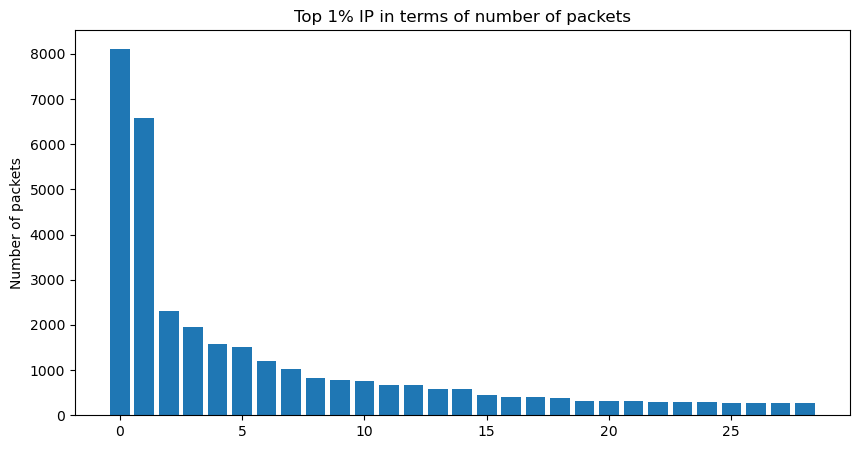

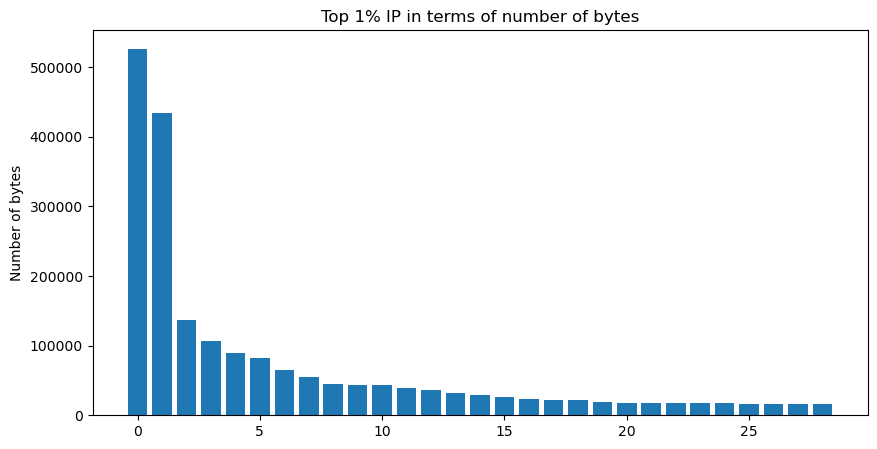

Number of packets that are the same in both lists: 27
IP:202.145.131.200	Number of packets:8115	Number of bytes:526758
IP:218.174.180.48	Number of packets:6577	Number of bytes:434082
IP:147.59.184.54	Number of packets:2313	Number of bytes:137322
IP:215.206.154.178	Number of packets:1963	Number of bytes:106010
IP:134.110.8.90	Number of packets:1588	Number of bytes:90096
IP:203.35.40.155	Number of packets:1519	Number of bytes:81842
IP:152.144.250.221	Number of packets:1207	Number of bytes:65222
IP:129.148.137.230	Number of packets:1029	Number of bytes:55574
IP:33.162.19.116	Number of packets:817	Number of bytes:44118
IP:202.145.132.54	Number of packets:774	Number of bytes:44860
IP:128.10.143.94	Number of packets:761	Number of bytes:44078
IP:134.161.222.237	Number of packets:665	Number of bytes:35910
IP:202.168.207.93	Number of packets:660	Number of bytes:22440
IP:214.52.129.160	Number of packets:592	Number of bytes:39072
IP:147.59.208.81	Number of packets:578	Number of bytes:31476
IP:219

In [9]:
#Read the dump file
packets=sc.rdpcap(f'packets0-3.dump')
#Generates a dictionary with the IP as key and the number of packets and the number of bytes as values
ip_packets={}
for packet in packets:
    if packet.haslayer(sc.IP):
        ip=packet[sc.IP].src
        if ip  in ip_packets:
            ip_packets[ip]=[ip_packets[ip][0]+1,ip_packets[ip][1]+len(packet)]
        else:
            ip_packets[ip]=[1,len(packet)]
#select the top 1% packets in terms of number of packets 
top_10_Npackets=sorted(ip_packets.items(), key=lambda x: x[1][0], reverse=True)[:len(ip_packets)//100]
#select the top 1% packets in terms of number of bytes
top_10_Nbytes=sorted(ip_packets.items(), key=lambda x: x[1][1], reverse=True)[:len(ip_packets)//100]

#plot the top 1% IP in terms of number of packets 
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(top_10_Npackets)),[x[1][0] for x in top_10_Npackets])
plt.title('Top 1% IP in terms of number of packets')
plt.ylabel('Number of packets')
plt.show()

#plot the top 10% IP in terms of number of bytes
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(top_10_Npackets)),[x[1][1] for x in top_10_Nbytes])
plt.title('Top 1% IP in terms of number of bytes')
plt.ylabel('Number of bytes')
plt.show()

#check the number of IP that are present in both  lists and sort them in descending order
total_top_IPs=set([x[0] for x in top_10_Npackets]).intersection(set([x[0] for x in top_10_Nbytes]))
total_top_IPs=sorted(total_top_IPs,key=lambda x: ip_packets[x][0],reverse=True)
print('Number of packets that are the same in both lists:',len(total_top_IPs))
#print the IP and the number of packets and bytes for each IP
for IP in total_top_IPs:
    print(f"IP:{IP}\tNumber of packets:{ip_packets[IP][0]}\tNumber of bytes:{ip_packets[IP][1]}")
        



In [11]:
packets[0]

<Ether  dst=00:90:69:ec:ad:5c src=00:0e:39:e3:34:00 type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=40 id=5069 flags=DF frag=0 ttl=122 proto=tcp chksum=0xbbec src=203.45.191.78 dst=39.173.126.237 |<TCP  sport=grf_port dport=www_http seq=1864242040 ack=2946491338 dataofs=5 reserved=0 flags=FA window=65535 chksum=0x59bf urgptr=0 |>>>

In [9]:
def  from_packetheader_to_binary(packet):
    #Converts the packet header to binary
    #Input: packet
    #Output: dictionary with the header fields in binary

    # Extract the IP layer from the packet
    ip_layer = packet.getlayer(sc.IP)
    # Construct the 160-bit IPv4 header string
    version = bin(4)[2:].zfill(4)  # IPv4 version number
    ihl = bin(ip_layer.ihl)[2:].zfill(4)  # Internet Header Length
    tos = bin(ip_layer.tos)[2:].zfill(8)  # Type of Service
    length = bin(ip_layer.len)[2:].zfill(16)  # Total Length
    id = bin(ip_layer.id)[2:].zfill(16)  # Identification
    flags = bin(int(ip_layer.flags))[2:].zfill(3)  # Flags
    offset = bin(ip_layer.frag)[2:].zfill(13)  # Fragment Offset
    ttl = bin(ip_layer.ttl)[2:].zfill(8)  # Time to Live
    protocol = bin(ip_layer.proto)[2:].zfill(8)  # Protocol
    checksum = bin(ip_layer.chksum)[2:].zfill(16)  # Header Checksum
    src = ''.join('{:08b}'.format(int(x)) for x in ip_layer.src.split('.'))  # Source IP address
    dst = ''.join('{:08b}'.format(int(x)) for x in ip_layer.dst.split('.'))  # Destination IP address

    return {
        "version": version,
        "ihl": ihl,
        "tos": tos,
        "total_length": length,
        "identification": id,
        "flags": flags,
        "fragment_offset": offset,
        "ttl": ttl,
        "protocol": protocol,
        "header_checksum": checksum,
        "source_ip": src,
        "dest_ip": dst
    }


def decode_ipv4_header(binary_str):
    #Decodes the binary string to a dictionary with the header fields
    #Input: binary string
    #Output: dictionary with the header fields

    version = int(binary_str[0:4], 2) # IPv4 version number
    ihl = int(binary_str[4:8], 2) # Internet Header Length
    tos = int(binary_str[8:16], 2) # Type of Service
    total_length = int(binary_str[16:32], 2) # Total Length
    identification = int(binary_str[32:48], 2) # Identification
    flags = int(binary_str[48:51], 2) # Flags
    fragment_offset = int(binary_str[51:64], 2) # Fragment Offset
    ttl = int(binary_str[64:72], 2) # Time to Live
    protocol = int(binary_str[72:80], 2) # Protocol
    header_checksum = int(binary_str[80:96], 2) # Header Checksum
    source_ip = '.'.join(str(int(binary_str[i:i+8], 2)) for i in range(96, 128, 8)) # Source IP address
    dest_ip = '.'.join(str(int(binary_str[i:i+8], 2)) for i in range(128, 160, 8)) # Destination IP address

    return {
        "version": version,
        "ihl": ihl,
        "tos": tos,
        "total_length": total_length,
        "identification": identification,
        "flags": flags,
        "fragment_offset": fragment_offset,
        "ttl": ttl,
        "protocol": protocol,
        "header_checksum": header_checksum,
        "source_ip": source_ip,
        "dest_ip": dest_ip
    }





            


In [10]:
#create a dataset containing the packet header in bit as X 
#and the label 1 if the IP is in the top 1% in terms of number of packets and bytes and 0 otherwise
version=[]
ihl=[]
tos=[]
total_length=[]
identification=[]
flags=[]
fragment_offset=[]
ttl=[]
protocol=[]
header_checksum=[]
source_ip=[]
dest_ip=[]
label=[]
for packet in packets:
    if packet.haslayer(sc.IP):
        ip=packet[sc.IP].src
        bits=from_packetheader_to_binary(packet)
        version.append(bits['version'])
        ihl.append(bits['ihl'])
        tos.append(bits['tos'])
        total_length.append(bits['total_length'])
        identification.append(bits['identification'])
        flags.append(bits['flags'])
        fragment_offset.append(bits['fragment_offset'])
        ttl.append(bits['ttl'])
        protocol.append(bits['protocol'])
        header_checksum.append(bits['header_checksum'])
        source_ip.append(bits['source_ip'])
        dest_ip.append(bits['dest_ip'])
        if ip in total_top_IPs:
            label.append(1)
        else:
            label.append(0)
dataset=pd.DataFrame({'version':version,'ihl':ihl,'tos':tos,'total_length':total_length,'identification':identification,'flags':flags,'fragment_offset':fragment_offset,'ttl':ttl,'protocol':protocol,'header_checksum':header_checksum,'source_ip':source_ip,'dest_ip':dest_ip,'label':label})
dataset.to_csv('dataset.csv',index=False)
dataset.head()

,version,ihl,tos,total_length,identification,flags,fragment_offset,ttl,protocol,header_checksum,source_ip,dest_ip,label
0,0100,0101,00000000,0000000000101000,0001001111001101,010,0000000000000,01111010,00000110,1011101111101100,11001011001011011011111101001110,00100111101011010111111011101101,0
1,0100,0101,00000000,0000010111011100,0101000011000000,010,0000000000000,00111000,00000110,0111110110001111,10010011001110111011100000110110,11010110111111100100110001011100,1
2,0100,0101,00000000,0000010111011100,0101000011000001,010,0000000000000,00111000,00000110,0111110110001110,10010011001110111011100000110110,11010110111111100100110001011100,1
3,0100,0101,00000000,0000000001001001,0000000111001010,000,0000000000000,00110110,00010001,1001111010010100,11001010000010001100010100001010,11001011100110101000100110011000,0
4,0100,0101,00000000,0000000000110100,1000101000101100,010,0000000000000,00111101,00000110,1101011001011110,11001010100100011000001111001000,11011010101011101011010000110000,1


In [11]:
Y=dataset[["label"]]
#N of ones 
print('Number of ones:',len(Y[Y['label']==1],),"\nNumber of samples:",len(Y))


Number of ones: 27920 
Number of samples: 60479
